In [67]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os, sys

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)
    
from load_ARSENL_data import set_binwidth

In [75]:
load_loc = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Figures\evaluation_loss\compare_deadtime_poisson'
fname_dead = r'\deadtimeTruerho5.00E+03MHz_use_sim_True.pkl'
fname_pois = r'\deadtimeFalserho5.00E+03MHz_use_sim_True.pkl'

use_sim_data = True

infile_dead = open(load_loc+fname_dead, 'rb')
infile_pois = open(load_loc+fname_pois, 'rb')
load_dead = pickle.load(infile_dead)
load_pois = pickle.load(infile_pois)

In [76]:
if use_sim_data:
    t_fine = load_dead[0]
    fit_rate_seg_dead = load_dead[1]
    true_flight_time = load_dead[2]
    true_rho = load_dead[3]
    flight_time = load_dead[4]
    n_shots = load_dead[5]
    t_min = load_dead[6]
    t_max = load_dead[7]
    dt = load_dead[8]

    fit_rate_seg_pois = load_pois[1]
else:
    t_fine = load_dead[0]
    fit_rate_seg_dead = load_dead[1]
    flight_time = load_dead[2]
    n_shots = load_dead[3]
    t_min = load_dead[4]
    t_max = load_dead[5]
    dt = load_dead[6]

    fit_rate_seg_pois = load_pois[1]

In [77]:
deadtime = 25e-9  # [s]
deadtime_n_bins = np.floor(deadtime / dt).astype(int)
active_ratio_hst = n_shots * np.ones(len(t_fine)-1)

for i in range(len(flight_time)):
    det_time = flight_time[i].item()

    # Only include detections that fall within fitting window
    if det_time >= (t_min-deadtime) and det_time <= t_max:
        det_bin_idx = np.argmin(abs(det_time - t_fine))  # Bin that detection falls into
        final_dead_bin = det_bin_idx + deadtime_n_bins  # Final bin index that deadtime occupies

        # Currently a crutch that assumes "dead" time >> potwindow. Will need to include "wrap around" to be more accurate
        # If final dead bin surpasses fit window, set it to the window upper bin
        if final_dead_bin > len(active_ratio_hst):
            final_dead_bin = len(active_ratio_hst)
        # If initial dead bin (detection bin) precedes fit window, set it to the window lower bin
        if det_time < t_min:
            det_bin_idx = 0
        active_ratio_hst[det_bin_idx:final_dead_bin+1] -= 1  # Remove "dead" region in active ratio
        
active_ratio_hst /= n_shots
AF = np.mean(active_ratio_hst)

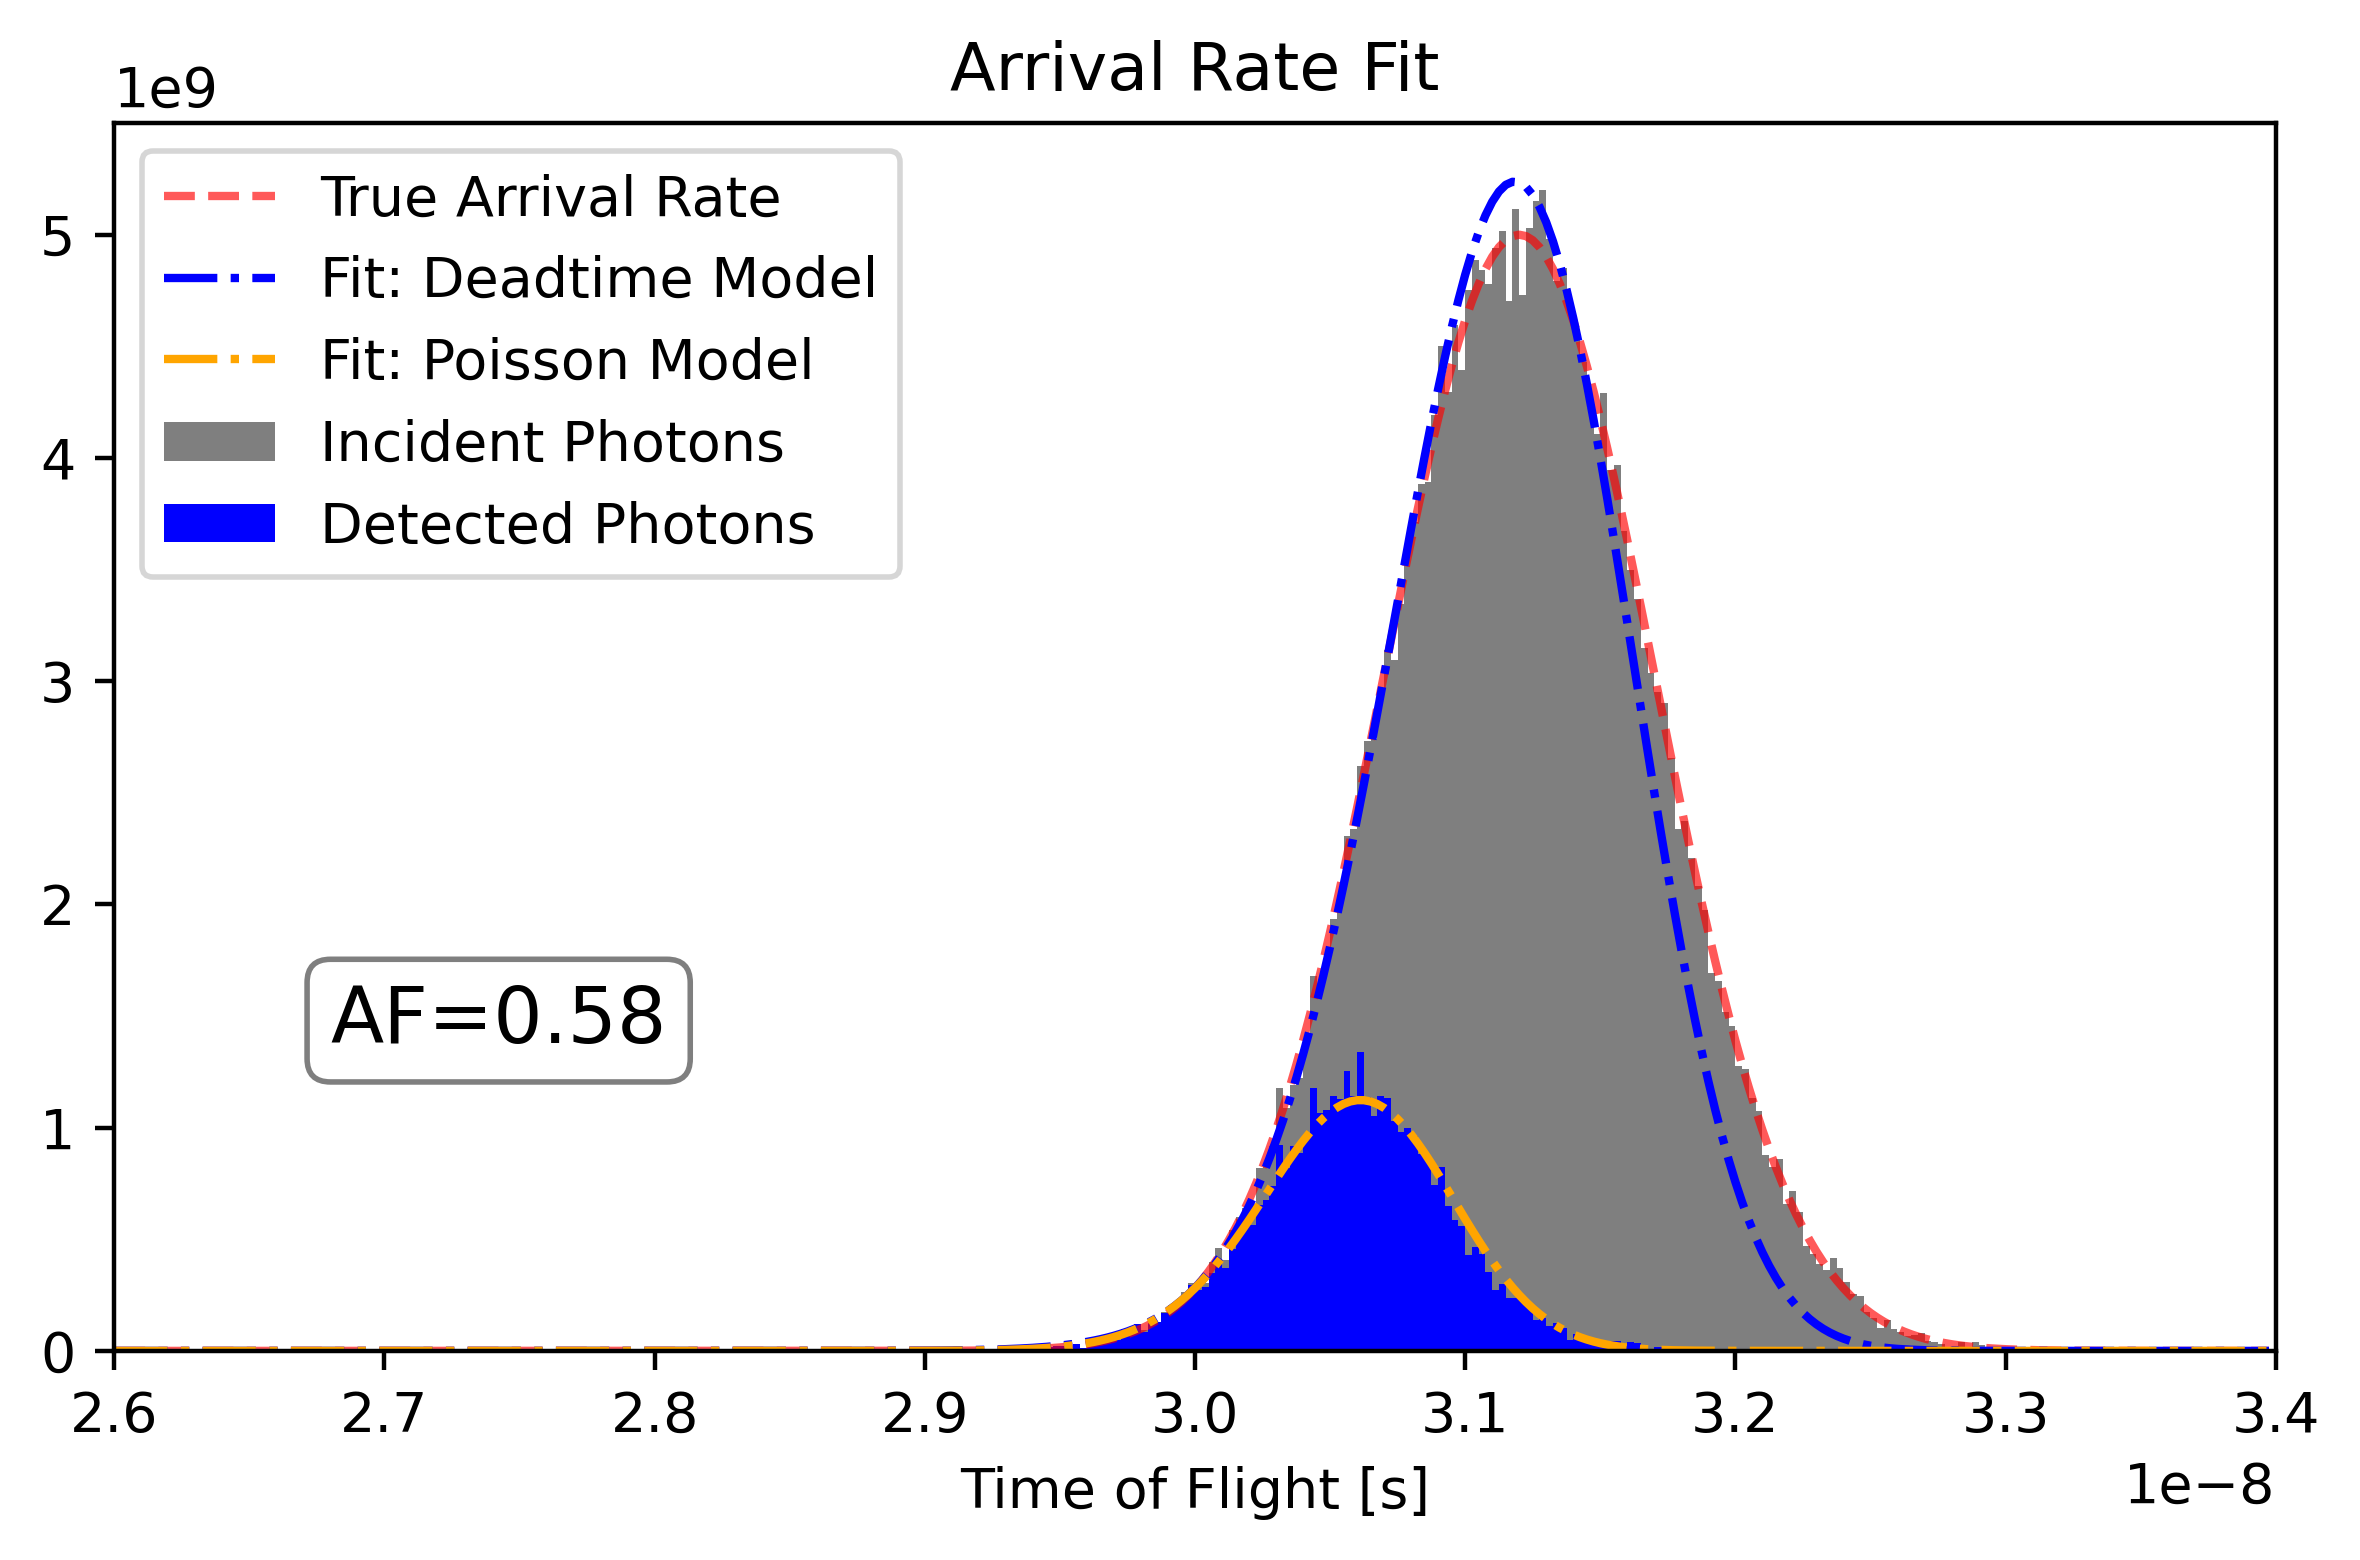

In [78]:
fig = plt.figure(figsize=(6,4), dpi=400)
ax = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
if use_sim_data:
    n, bins = np.histogram(true_flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='black', alpha=0.5, label='Incident Photons')

    ax.plot(t_fine, true_rho, '--', color='red', alpha=0.65, label='True Arrival Rate')
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='blue', label='Detected Photons')
else:
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='blue', alpha=0.5, label='Detected Photons')

# Arrival rate fit
ax.plot(t_fine, fit_rate_seg_dead, '-.', markersize=5, color='blue', label='Fit: Deadtime Model')
ax.plot(t_fine, fit_rate_seg_pois, '-.', markersize=5, color='orange', label='Fit: Poisson Model')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('Time of Flight [s]')
ax.set_xlim([2.6e-8, t_max])
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
# ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.1, 0.3, 'AF={:.2f}'.format(AF), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.legend()

save_dir = r'C:\Users\Grant\Downloads'
save_plt_file = r'\{}.png'.format(fname_dead)
fig.savefig(save_dir + save_plt_file)
plt.show()
